In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import sys
import traceback
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn
import dataclasses
import os



import pickle

import dill

In [2]:
dataset: Literal["ihdp","jobs"] = "ihdp"

In [3]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())

sns.set_theme(style="darkgrid",context="paper")

import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [4]:
from assignment2.a2_utils.seed_utils import *

from assignment2.a2_utils.misc_utils import *

import assignment2.a2_utils.seed_utils as seed_utils
import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml


""

''

# IHDP dataset processing


In [5]:

ihdp_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full IHDP dataset (with supplementary t0 and t1 info) as a dataframe"

ihdp_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x22,x23,x24,t,yf,ycf,ite,tcf,t0,t1
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,0,1,1,4.771232,-0.298509,4.657928,0,-0.298509,4.771232
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,0,0,0,0,2.956273,5.783770,3.428604,1,2.956273,5.783770
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,0,0,1,0,4.164164,7.055789,3.658195,1,4.164164,7.055789
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,0,0,0,1,6.172307,1.379697,4.585505,0,1.379697,6.172307
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,0,0,0,1,7.834469,2.747986,4.265591,0,2.747986,7.834469


In [6]:
ihdp_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      747 non-null    float64
 1   x1      747 non-null    float64
 2   x2      747 non-null    float64
 3   x3      747 non-null    float64
 4   x4      747 non-null    float64
 5   x5      747 non-null    float64
 6   x6      747 non-null    uint8  
 7   x7      747 non-null    uint8  
 8   x8      747 non-null    uint8  
 9   x9      747 non-null    uint8  
 10  x10     747 non-null    uint8  
 11  x11     747 non-null    uint8  
 12  x12     747 non-null    uint8  
 13  x13     747 non-null    uint8  
 14  x14     747 non-null    uint8  
 15  x15     747 non-null    uint8  
 16  x16     747 non-null    uint8  
 17  x17     747 non-null    uint8  
 18  x18     747 non-null    uint8  
 19  x19     747 non-null    uint8  
 20  x20     747 non-null    uint8  
 21  x21     747 non-null    uint8  
 22  x2

In [7]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = ihdp_full,
    test_proportion = 0.1,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "yf",
    e_column = "e",
    default_e_if_e_not_present = 1,
    ycf_column= "ycf",
    t0_column= "t0",
    t1_column = "t1",
    ite_column = "ite"
)


In [8]:
dfm.save_self()

pickling self as \ihdp\ihdp DataframeManager.pickle...
pickled!


True

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection._validation import NotFittedError
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.linear_model import ARDRegression, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.metrics import r2_score, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.utils import Bunch
from math import inf

set_config(display="diagram")



# Part 3 - Simple Learners

In [10]:
%%time

rf_min_samples = [2,4,6,8]
rf_min_impurity_decrease =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_max_features = [None,"sqrt","log2",1,2]
rf_ccp_alpha =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_n_estimators = [50,100,150,200]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease": rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 500
n_resources: 7
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
----------
iter: 1
n_candidates: 63
n_resources: 7
Fitting 10 folds for each of 63 candidates, totalling 630 fits
----------
iter: 2
n_candidates: 8
n_resources: 7
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary Random Forest simple ihdp
	test score:	0.6498332062394994
	train score:0.7709014983988103
	yf score:	0.8199018876576412
	ycf score:	0.6957497020343439
	t0 score:	0.6388679444069123
	t1 score:	0.07132932382614265
	ite score:	0.47545168932482584
	abs ATE:	0.05281883906596496
	PEHE:   	0.6222530876097533
	abs ATT:	0.04930649712554924
	p. risk:	-5.508298891488975

--- 1/4 END ---
-- 10-fold attempt 2/4 st

In [11]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [12]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple ihdp
	test score:	0.6711888497393727
	train score:0.7770952403846507
	yf score:	0.8244244800269346
	ycf score:	0.6955888784923343
	t0 score:	0.6494467536339077
	t1 score:	0.0662953849178406
	ite score:	0.5987418622260066
	abs ATE:	0.057904874589408184
	PEHE:   	0.5442347149270812
	abs ATT:	0.0764029146957661
	p. risk:	-5.503193636700893
	best params:
		estimator__ccp_alpha : 0.0012247448713915891
		estimator__max_features : None
		estimator__min_impurity_decrease : 0.013554030054147676
		estimator__min_samples_split : 6
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestRegressor(ccp_alpha=0.0012247448713915891,
                                        max_features=None,
                                        min_impurity_decrease=0.013554030054147676,
                                        min_samples_split=6,
                                        random_state=42))])

In [13]:
rf_simple_best.save_me()

Pickling results to: \ihdp\ihdp Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Random Forest simple feature importances.pdf


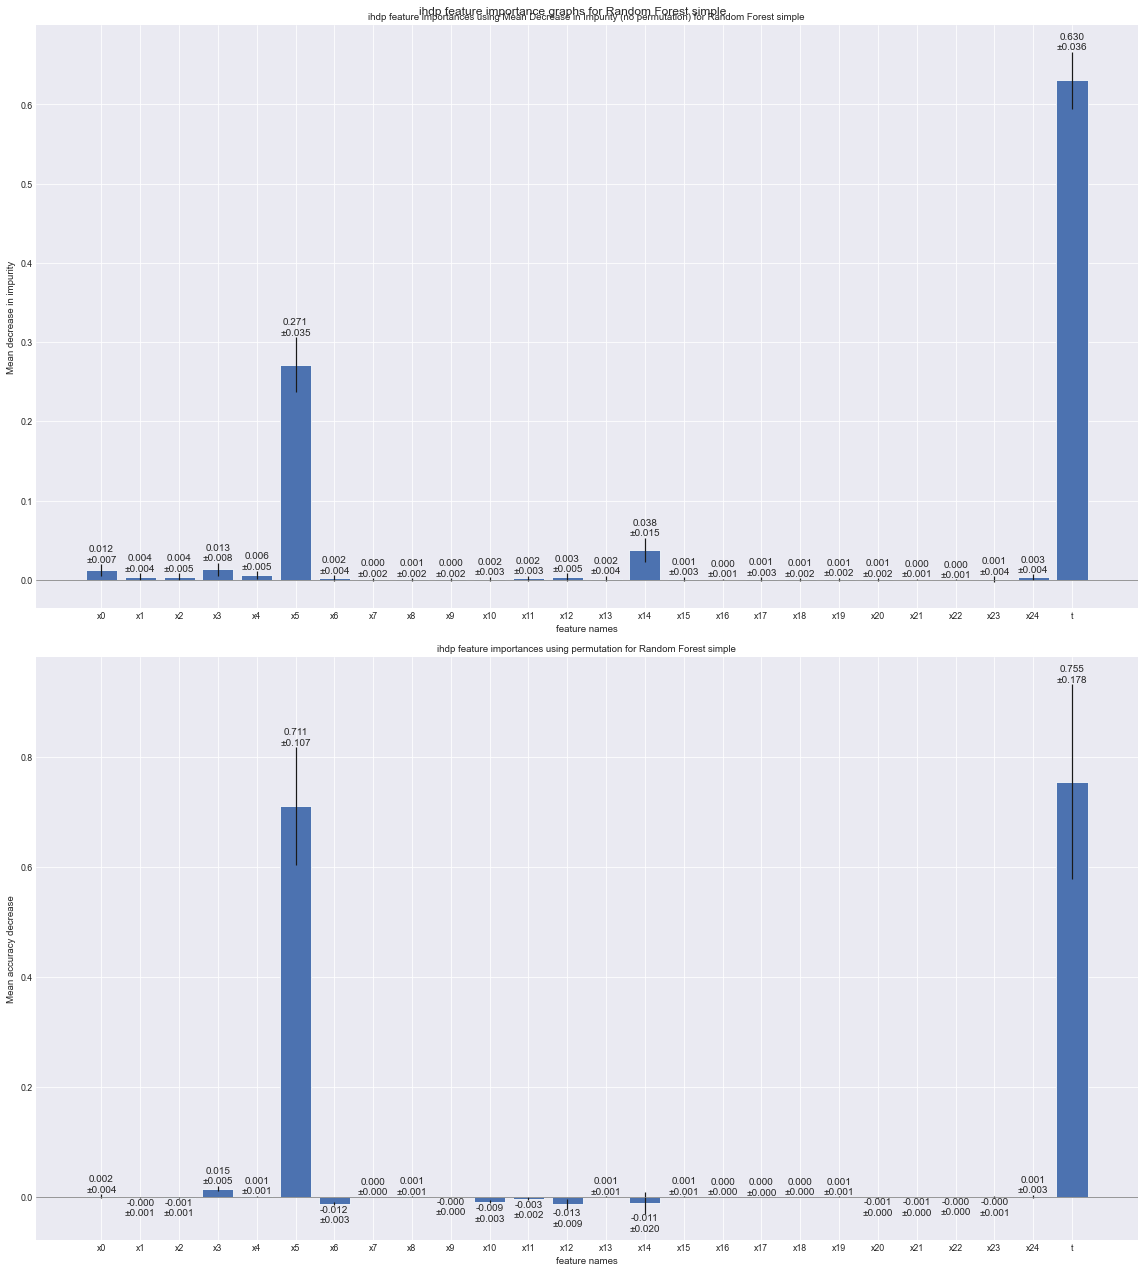

In [14]:
rf_simple_best.importance_plotter().show()

In [17]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985

--- 1/3 END ---
-- 10-fold attempt 2/

In [18]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [19]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.0880853724951618
	ite score:	-0.0008744474291235704
	abs ATE:	0.02540628505630016
	PEHE:   	0.8595360866486239
	abs ATT:	0.10410522166326874
	p. risk:	-5.4930213795885985
	best params:
		estimator__alpha_1 : 1e-07
		estimator__alpha_2 : 1e-05
		estimator__lambda_1 : 1e-05
		estimator__lambda_2 : 1e-05
		estimator__threshold_lambda : 10000.0
		estimator__tol : 0.01
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05,
                                lambda_2=1e-05, n_iter=14, tol=0.01))])

In [20]:
ard_simple_best.save_me()

Pickling results to: \ihdp\ihdp ARD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp ARD simple feature importances.pdf


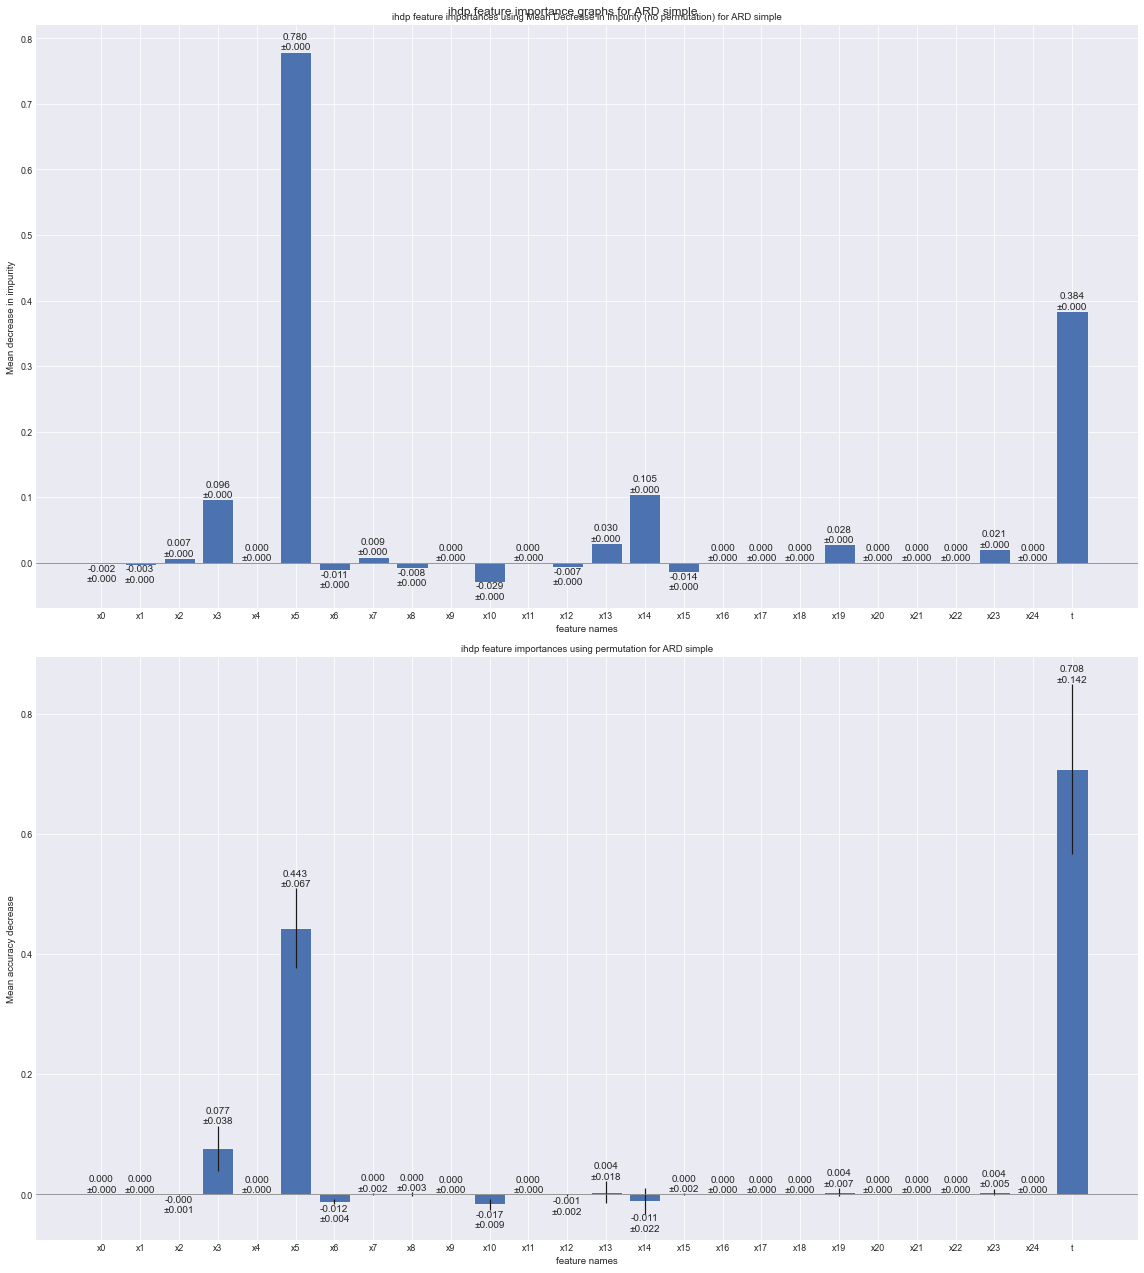

In [21]:
ard_simple_best.importance_plotter().show()

In [22]:
%%time

sgd_max_iter: List[int] = [500,1000,1500]
sgd_alpha: List[float] = [0.001, 0.0001, 0.00001]
sgd_learning_rate: List[str] =  ["constant","optimal","invscaling","adaptive"]
sgd_power_t: List[float] = [0.25,0.5,0.75]
sgd_l1_ratio: List[float] = [0, 0.15, 0.5, 0.85, 1]


sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDRegressor(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 180
n_resources: 22
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 8
n_resources: 22
Fitting 10 folds for each of 8 candidates, totalling 80 fits
best from this iteration: 
GridSearchResults summary sgd simple ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources

In [23]:

sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_searched
)



In [24]:

print(sgd_simple_best.info)

sgd_simple_best.best_estimator_


GridSearchResults summary sgd simple ihdp
	test score:	0.4425780268844929
	train score:0.6269645946519098
	yf score:	0.6427940441859836
	ycf score:	0.5531127392764995
	t0 score:	0.3320840758703357
	t1 score:	-0.4380164106561475
	ite score:	-0.03812289984639472
	abs ATE:	0.1677518344022335
	PEHE:   	0.8753841915845768
	abs ATT:	0.2949318616657459
	p. risk:	-5.323169480673895
	best params:
		estimator__alpha : 0.001
		estimator__l1_ratio : 1
		estimator__learning_rate : invscaling
		estimator__power_t : 0.5
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1,
                               max_iter=22, penalty='elasticnet', power_t=0.5,
                               random_state=42))])

In [25]:
sgd_simple_best.save_me()

Pickling results to: \ihdp\ihdp sgd simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp sgd simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp sgd simple feature importances.pdf


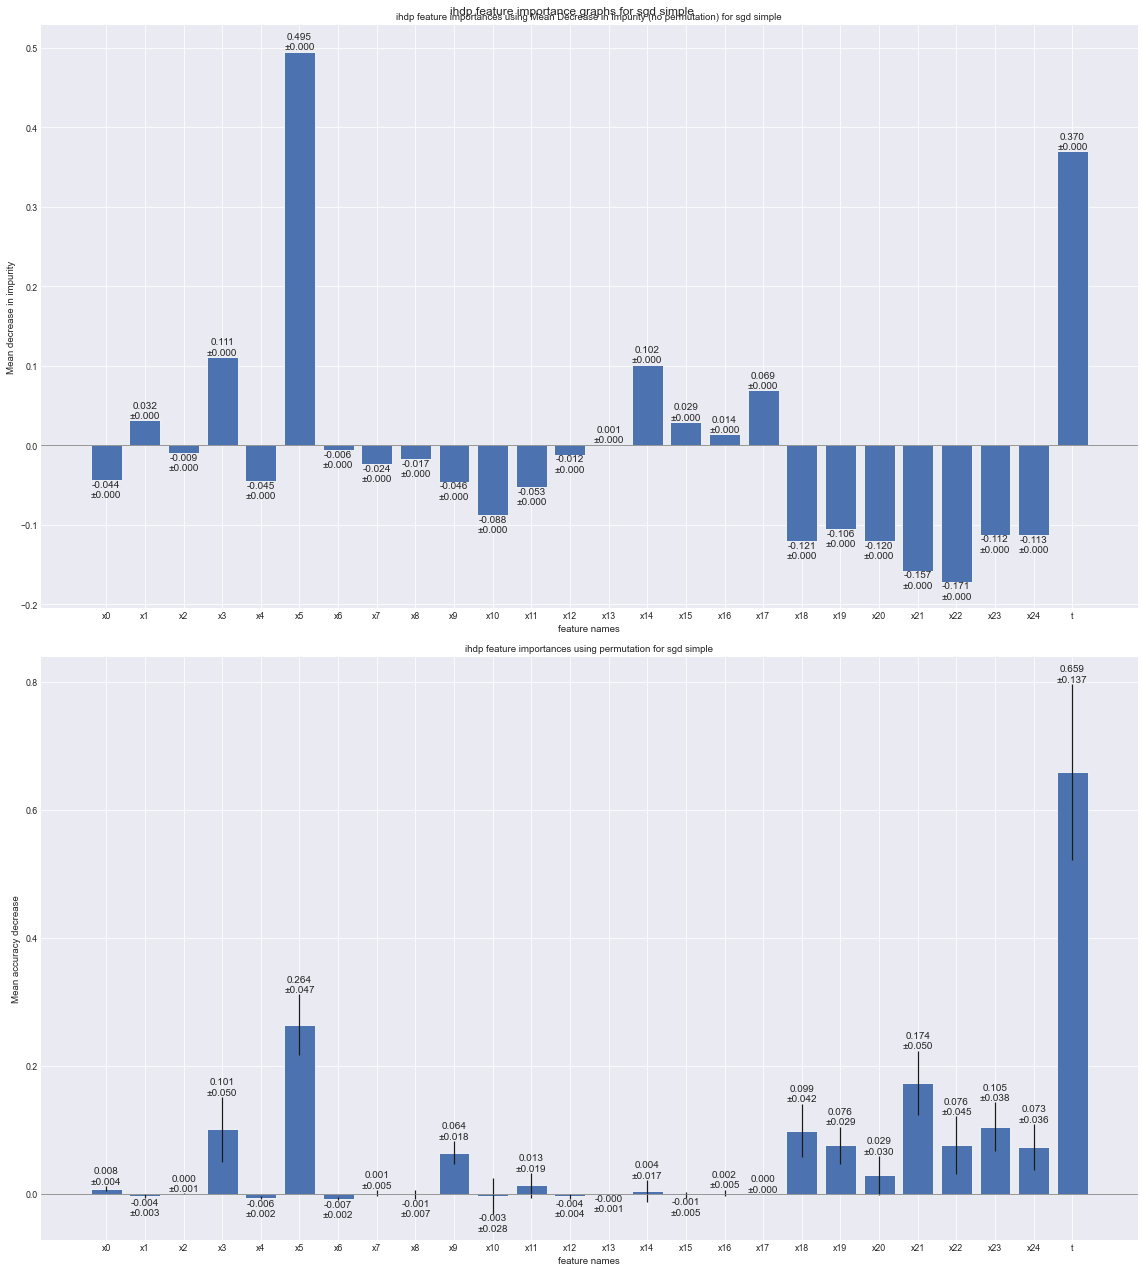

In [26]:
sgd_simple_best.importance_plotter().show()

In [27]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 0.9, 1.0, 1.1, 1.2]
adaboost_loss: List[str]= ["linear", "square", "exponential"]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_searched],
            RandomForestRegressor(random_state=seed()),
            RandomForestRegressor(random_state=seed(), max_depth=10),
            DecisionTreeRegressor(random_state=seed()),
            DecisionTreeRegressor(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 120
n_resources: 1
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
----------
iter: 1
n_candidates: 24
n_resources: 5
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 5
n_resources: 25
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6568394899084423
	train score:0.7682768481370744
	yf score:	0.9058507907846488
	ycf score:	0.681421738643244
	t0 score:	0.7768218370069999
	t1 score:	0.07173281319613156
	ite score:	0.2187550059315868
	abs ATE:	0.07090226193486426
	PEHE:   	0.7593953573006458
	abs ATT:	0.05731481880911815
	p. risk:	-5.448163792199852

--- 1/3 END ---
-- 10-fold attemp

In [28]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [29]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6758303538737988
	train score:0.7736248452799307
	yf score:	0.8683611400110817
	ycf score:	0.6701451220431061
	t0 score:	0.7160187286412032
	t1 score:	0.01629939345746978
	ite score:	0.31060774268238445
	abs ATE:	0.07872125202892777
	PEHE:   	0.7133579648434931
	abs ATT:	0.07922835602497535
	p. risk:	-5.447196775742499
	best params:
		estimator__base_estimator : RandomForestRegressor(ccp_alpha=0.013554030054147676, max_features=None,
                      min_impurity_decrease=0, min_samples_split=6,
                      n_estimators=12, random_state=42)
		estimator__learning_rate : 0.9
		estimator__loss : linear
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=RandomForestRegressor(ccp_alpha=0.013554030054147676,
                                                                         max_features=None,
                                                                         min_impurity_decrease=0,
                                                                         min_samples_split=6,
                                                                         n_estimators=12,
                                                                         random_state=42),
                                    learning_rate=0.9, n_estimators=7,
                                    random_state=42))])

In [30]:
ada_rf_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost Random Forest simple feature importances.pdf


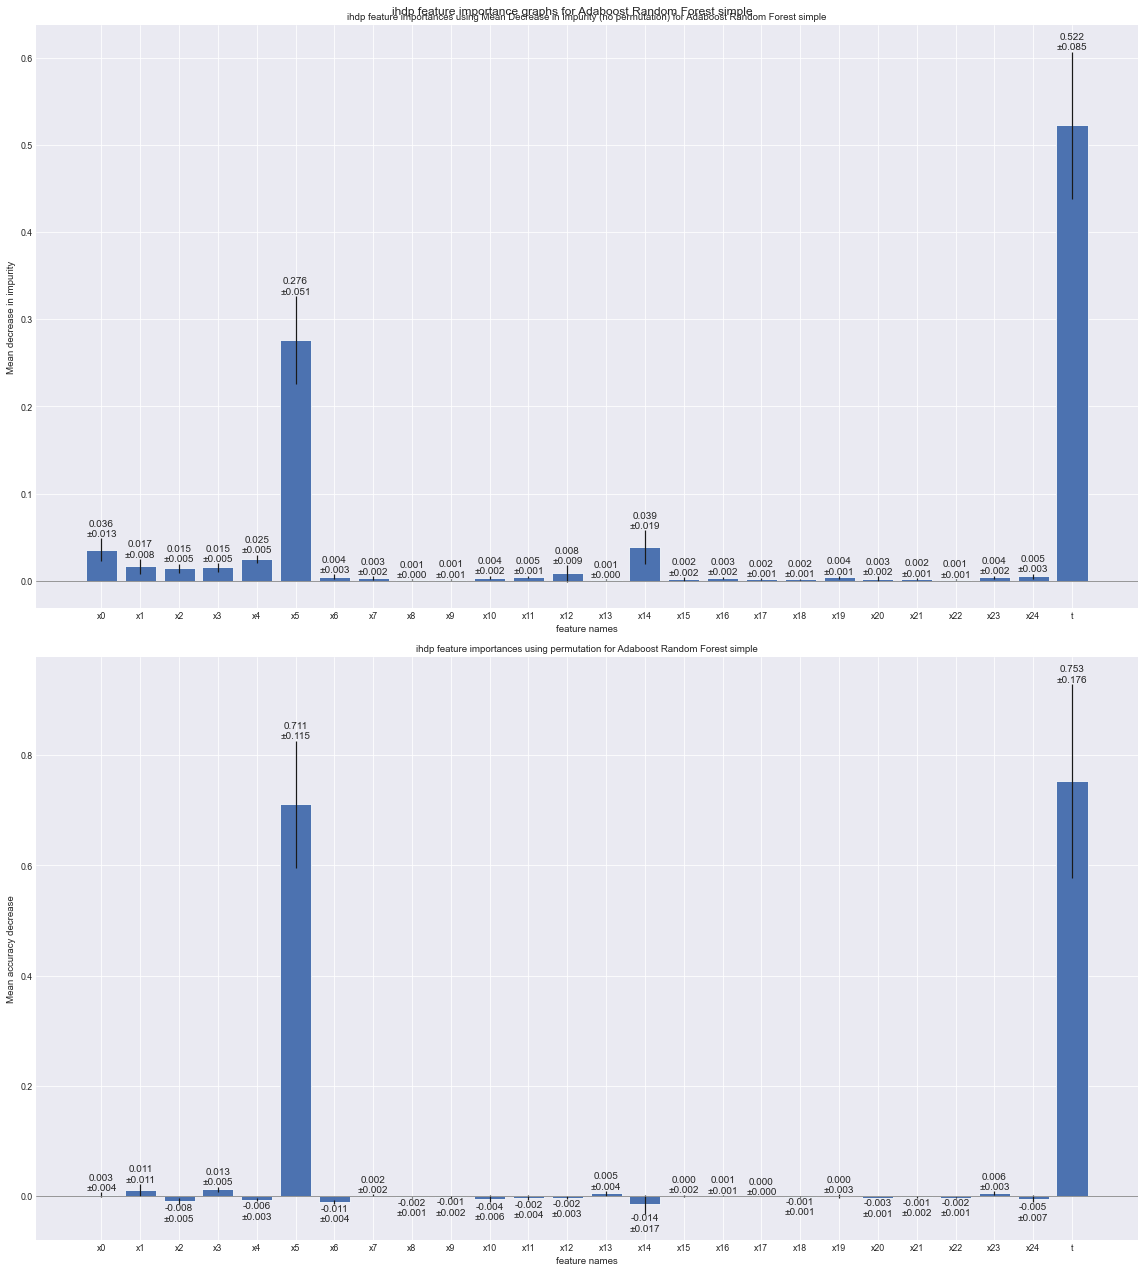

In [31]:
ada_rf_simple_best.importance_plotter().show()

In [32]:
%%time

ada_ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            est for est in
            misc_utils.chain_1(
                [pl.clone_best_final_estimator for pl in ard_simple_searched],
                ARDRegression()
            )
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)



-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 60
n_resources: 1
Fitting 10 folds for each of 60 candidates, totalling 600 fits
----------
iter: 1
n_candidates: 12
n_resources: 5
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 3
n_resources: 25
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best from this iteration: 
GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.4814613271155289
	train score:0.6964417538154005
	yf score:	0.70466583841806
	ycf score:	0.6469547945746504
	t0 score:	0.4620027411114326
	t1 score:	-0.16574902731910512
	ite score:	-0.037712912703367074
	abs ATE:	0.18672155290622738
	PEHE:   	0.8752113162411824
	abs ATT:	0.1286802065044652
	p. risk:	-5.480629855536226

--- 1/3 END ---
-- 10-fold attempt 2/3 start

In [33]:

ada_ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_searched
)




In [34]:


print(ada_ard_simple_best.info)


ada_ard_simple_best.best_estimator_


GridSearchResults summary Adaboost ARD simple ihdp
	test score:	0.5255486992764248
	train score:0.7093472513204686
	yf score:	0.7165702033736651
	ycf score:	0.656705158432112
	t0 score:	0.484748523916014
	t1 score:	-0.13544897516985777
	ite score:	-0.0004252961101625097
	abs ATE:	0.12184449536201702
	PEHE:   	0.859343202770986
	abs ATT:	0.09551798951337886
	p. risk:	-5.4832020535436
	best params:
		estimator__base_estimator : ARDRegression(alpha_1=1e-07, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-05,
              n_iter=16, tol=0.01)
		estimator__learning_rate : 0.9
		estimator__loss : exponential
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=ARDRegression(alpha_1=1e-07,
                                                                 alpha_2=1e-05,
                                                                 lambda_1=1e-05,
                                                                 lambda_2=1e-05,
                                                                 n_iter=16,
                                                                 tol=0.01),
                                    learning_rate=0.9, loss='exponential',
                                    n_estimators=7, random_state=42))])

In [35]:
ada_ard_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost ARD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost ARD simple feature importances.pdf


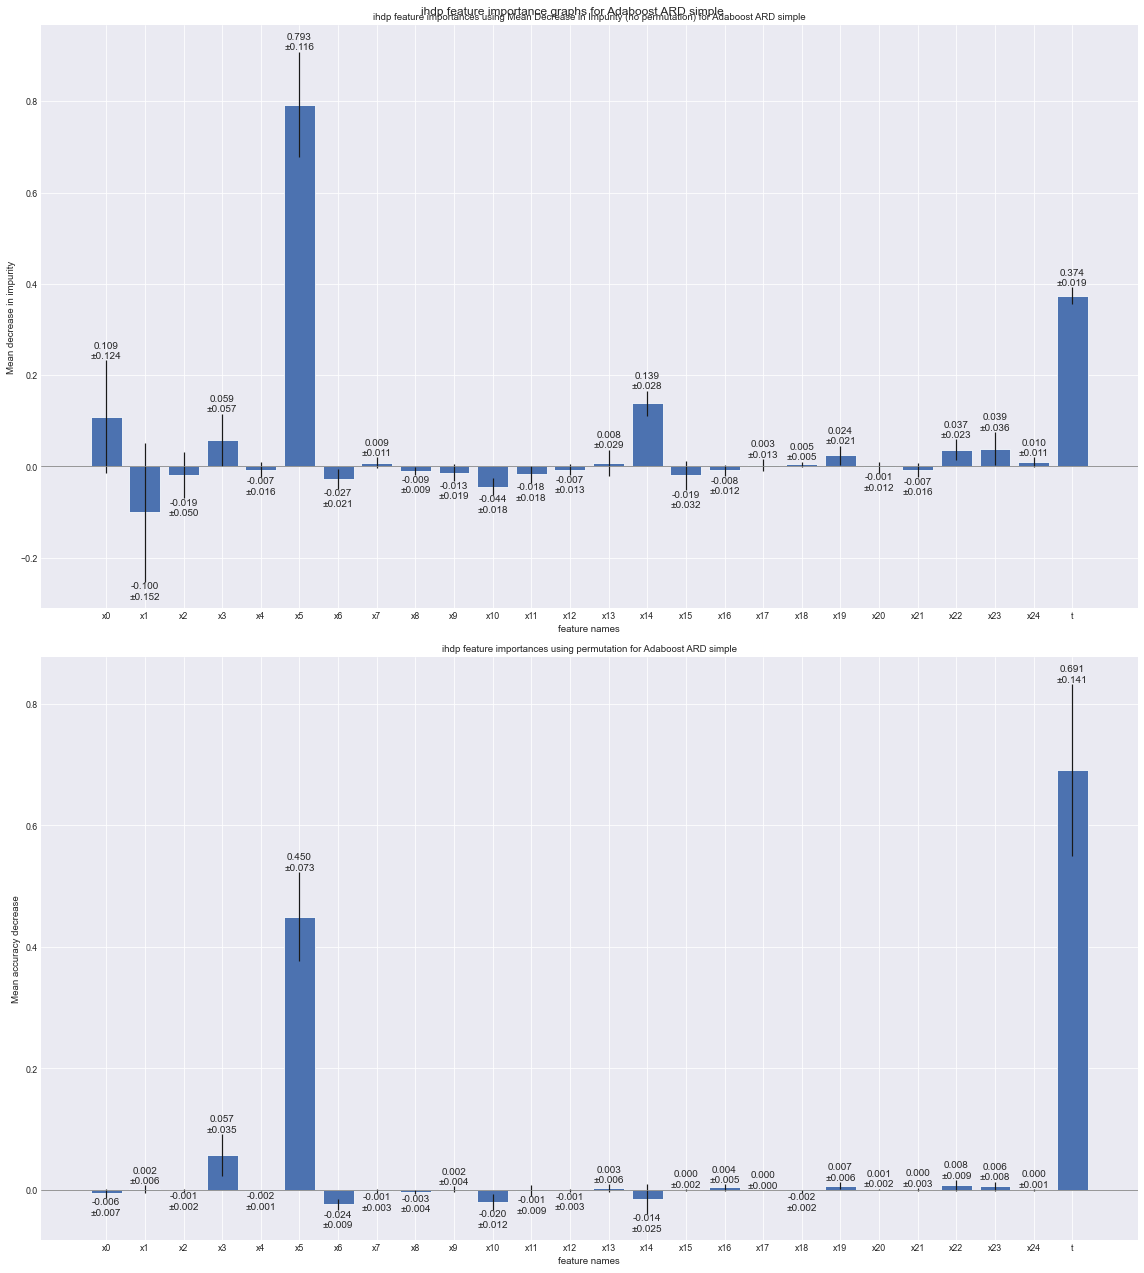

In [36]:
ada_ard_simple_best.importance_plotter().show()

In [37]:
%%time

ada_sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)


-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 45
n_resources: 1
Fitting 10 folds for each of 45 candidates, totalling 450 fits
----------
iter: 1
n_candidates: 9
n_resources: 5
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost SGD simple ihdp
	test score:	0.45364469514273087
	train score:0.614238158442269
	yf score:	0.6445905139546341
	ycf score:	0.531520027765997
	t0 score:	0.33151027672790045
	t1 score:	-0.49948952170239624
	ite score:	-0.23515378541777965
	abs ATE:	0.4179980508943113
	PEHE:   	0.9548492927379986
	abs ATT:	0.3307426921249532
	p. risk:	-5.435686848772482

--- 1/3 END ---
-- 10-fold attempt 2/3 start --

In [38]:
ada_sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_searched
)

In [39]:

print(ada_sgd_simple_best.info)

ada_sgd_simple_best.best_estimator_


GridSearchResults summary Adaboost SGD simple ihdp
	test score:	0.45364469514273087
	train score:0.614238158442269
	yf score:	0.6445905139546341
	ycf score:	0.531520027765997
	t0 score:	0.33151027672790045
	t1 score:	-0.49948952170239624
	ite score:	-0.23515378541777965
	abs ATE:	0.4179980508943113
	PEHE:   	0.9548492927379986
	abs ATT:	0.3307426921249532
	p. risk:	-5.435686848772482
	best params:
		estimator__base_estimator : SGDRegressor(alpha=0.001, early_stopping=True, l1_ratio=1, max_iter=32,
             penalty='elasticnet', power_t=0.5, random_state=42)
		estimator__learning_rate : 0.8
		estimator__loss : linear
		estimator__n_estimators : 25


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostRegressor(base_estimator=SGDRegressor(alpha=0.001,
                                                                early_stopping=True,
                                                                l1_ratio=1,
                                                                max_iter=32,
                                                                penalty='elasticnet',
                                                                power_t=0.5,
                                                                random_state=42),
                                    learning_rate=0.8, n_estimators=25,
                                    random_state=42))])

In [40]:
ada_sgd_simple_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost SGD simple results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost SGD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost SGD simple feature importances.pdf


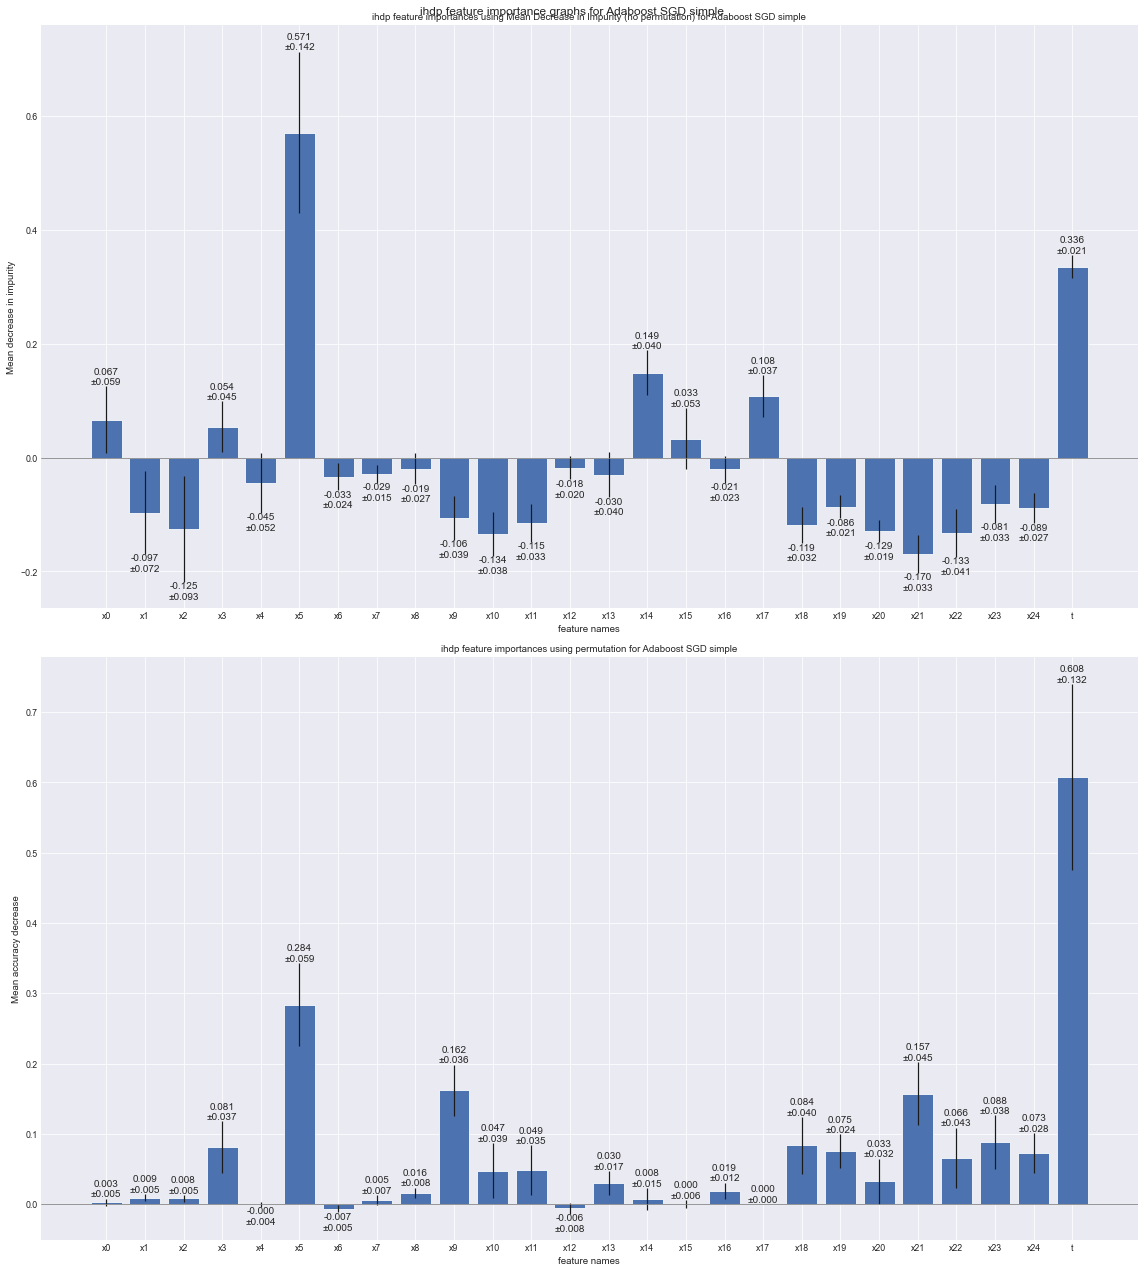

In [41]:
ada_sgd_simple_best.importance_plotter().show()

In [42]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    sgd_simple_best,
    ada_rf_simple_best,
    ada_ard_simple_best,
    ada_sgd_simple_best
]

all_simple_best.sort(reverse=True)


In [43]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

GridSearchResults summary Adaboost Random Forest simple ihdp
	test score:	0.6758303538737988
	train score:0.7736248452799307
	yf score:	0.8683611400110817
	ycf score:	0.6701451220431061
	t0 score:	0.7160187286412032
	t1 score:	0.01629939345746978
	ite score:	0.31060774268238445
	abs ATE:	0.07872125202892777
	PEHE:   	0.7133579648434931
	abs ATT:	0.07922835602497535
	p. risk:	-5.447196775742499
GridSearchResults summary Random Forest simple ihdp
	test score:	0.6711888497393727
	train score:0.7770952403846507
	yf score:	0.8244244800269346
	ycf score:	0.6955888784923343
	t0 score:	0.6494467536339077
	t1 score:	0.0662953849178406
	ite score:	0.5987418622260066
	abs ATE:	0.057904874589408184
	PEHE:   	0.5442347149270812
	abs ATT:	0.0764029146957661
	p. risk:	-5.503193636700893
GridSearchResults summary ARD simple ihdp
	test score:	0.5564596977895747
	train score:0.7174340703816985
	yf score:	0.7230858128688201
	ycf score:	0.6696308622344906
	t0 score:	0.49420677538586866
	t1 score:	-0.08808

In [44]:
best_simple_est: slearner.PPipeline = max(all_simple_best).best_estimator_

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [45]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [46]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":  rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features":rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": rf_ccp_alpha,
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

-- 10-fold attempt 1/4 start --
max: 50, min: 7, factor: 8
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 1000
n_resources: 7
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
----------
iter: 1
n_candidates: 125
n_resources: 7
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
----------
iter: 2
n_candidates: 16
n_resources: 7
Fitting 10 folds for each of 16 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 2
n_resources: 7
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.5248579545454546
	train score:0.648983423983424
	yf score:	0.6589596743657705

--- 1/4 END ---
-- 10-fold attempt 2/4 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_r

In [47]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [48]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7599431818181818
	train score:0.6591368816368817
	yf score:	0.891056891329042
	best params:
		estimator__ccp_alpha : 0
		estimator__class_weight : balanced
		estimator__max_features : 2
		estimator__min_impurity_decrease : 0
		estimator__min_samples_split : 6
		estimator__n_estimators : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0, class_weight='balanced',
                                         max_features=2,
                                         min_impurity_decrease=0,
                                         min_samples_split=6, n_estimators=14,
                                         random_state=42))])

In [49]:
rf_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Random Forest IPSW feature importances.pdf


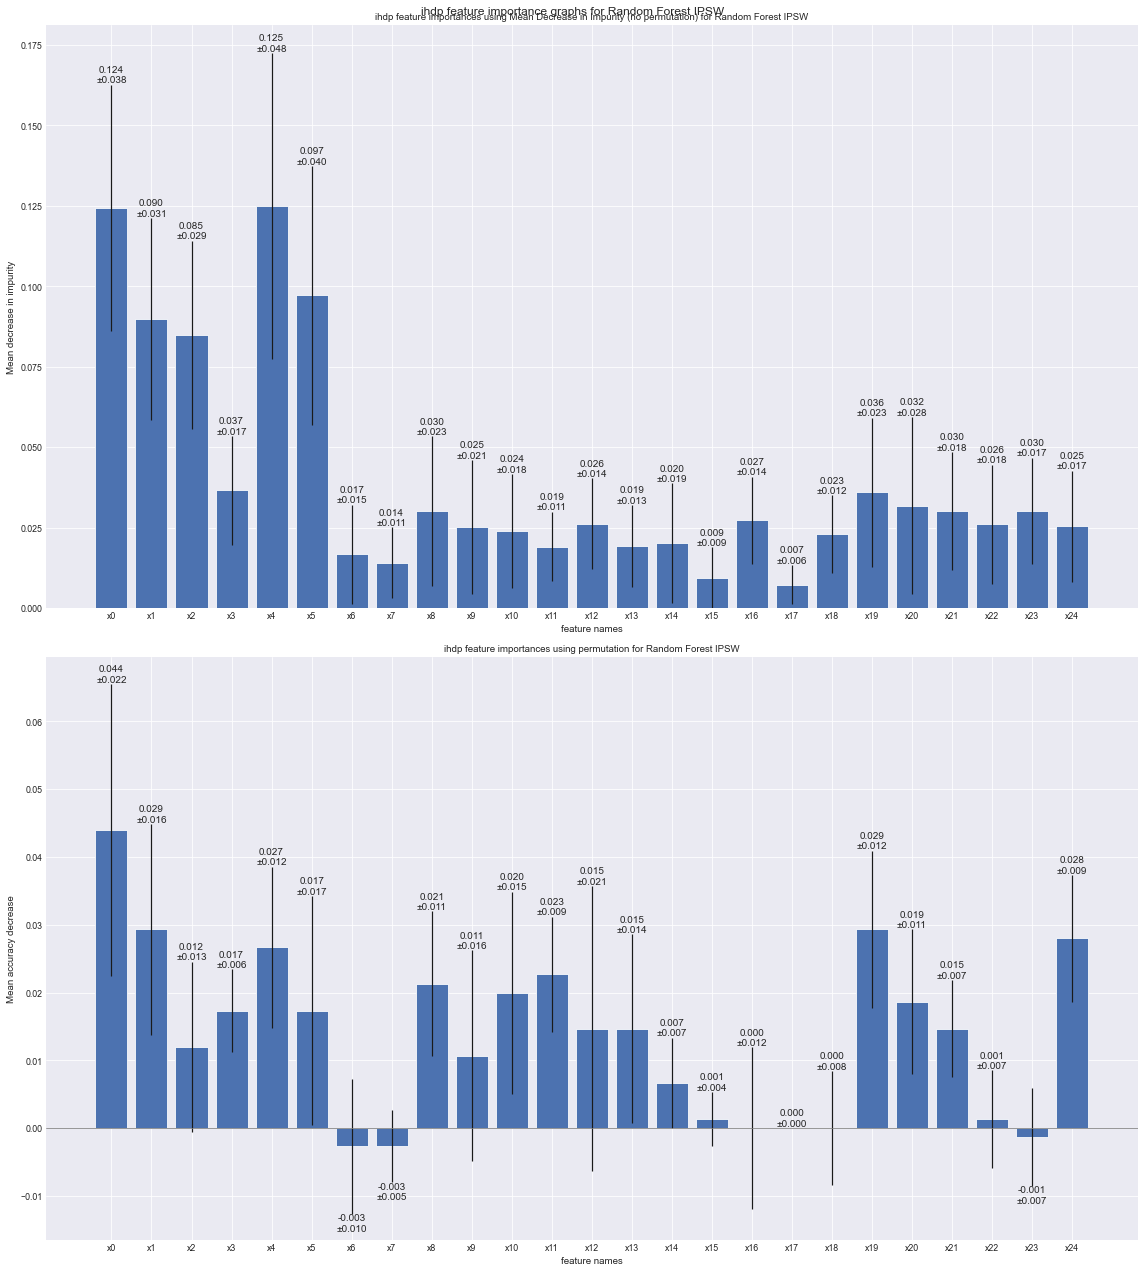

In [50]:
rf_ipsw_best.importance_plotter().show()

In [51]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log",
        penalty="elasticnet"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio,
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="sgd IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)


-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 360
n_resources: 22
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 16
n_resources: 22
Fitting 10 folds for each of 16 candidates, totalling 160 fits
best from this iteration: 
GridSearchResults summary sgd IPSW ihdp
	test score:	0.7982954545454546
	train score:0.6005529655529656
	yf score:	0.6342945380537675

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 360
n_resources: 32
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 12
n_resources: 32
Fit

In [52]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

In [53]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

GridSearchResults summary sgd IPSW ihdp
	test score:	0.7982954545454546
	train score:0.6005529655529656
	yf score:	0.6342945380537675
	best params:
		estimator__alpha : 1e-05
		estimator__class_weight : balanced
		estimator__l1_ratio : 0.15
		estimator__learning_rate : optimal
		estimator__power_t : 0.5
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=1e-05, class_weight='balanced',
                                early_stopping=True, loss='log', max_iter=22,
                                n_jobs=-1, penalty='elasticnet',
                                random_state=42))])

In [54]:

sgd_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp sgd IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp sgd IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp sgd IPSW feature importances.pdf


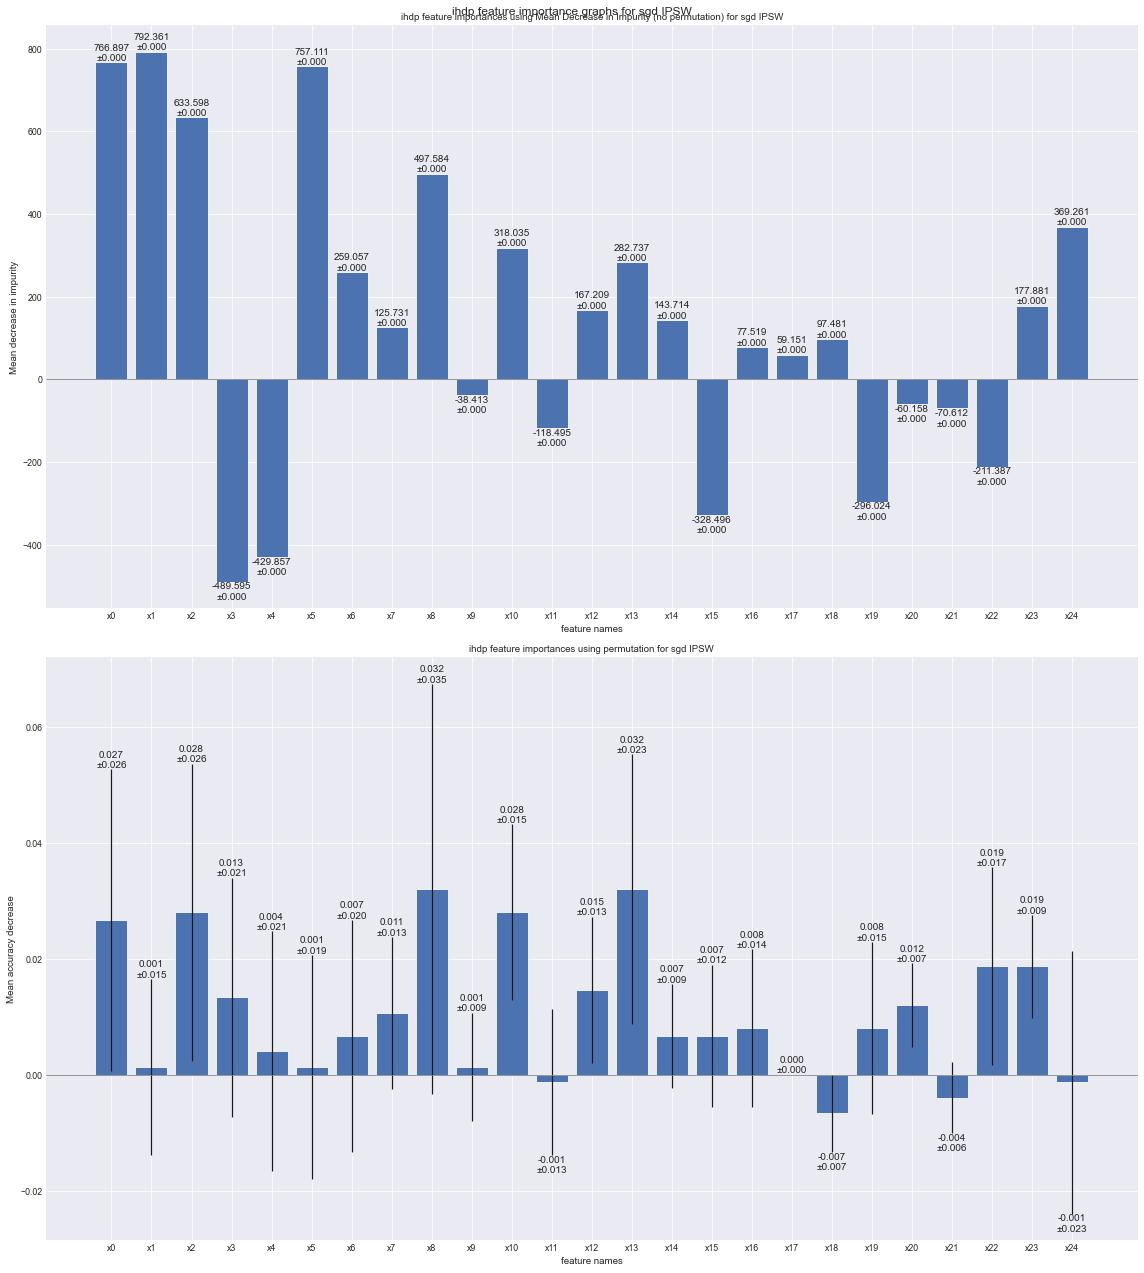

In [55]:

sgd_ipsw_best.importance_plotter().show()

In [56]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 40
n_resources: 1
Fitting 10 folds for each of 40 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 8
n_resources: 5
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 2
n_candidates: 2
n_resources: 25
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6605113636363635
	train score:0.6408883708883709
	yf score:	0.8769642180992048

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 40
n_resources: 7
Fitting 10 fo

In [57]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [58]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6974431818181819
	train score:0.6799572649572649
	yf score:	0.9587869178341537
	best params:
		estimator__base_estimator : RandomForestClassifier(ccp_alpha=0, class_weight='balanced', max_features=2,
                       min_impurity_decrease=0, min_samples_split=6,
                       n_estimators=14, random_state=42)
		estimator__learning_rate : 0.8
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=RandomForestClassifier(ccp_alpha=0,
                                                                           class_weight='balanced',
                                                                           max_features=2,
                                                                           min_impurity_decrease=0,
                                                                           min_samples_split=6,
                                                                           n_estimators=14,
                                                                           random_state=42),
                                     learning_rate=0.8, n_estimators=7,
                                     random_state=42))])

In [59]:

ada_rf_ipsw_best.save_me()

Pickling results to: \ihdp\ihdp Adaboost Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \ihdp\ihdp Adaboost Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \ihdp\ihdp Adaboost Random Forest IPSW feature importances.pdf


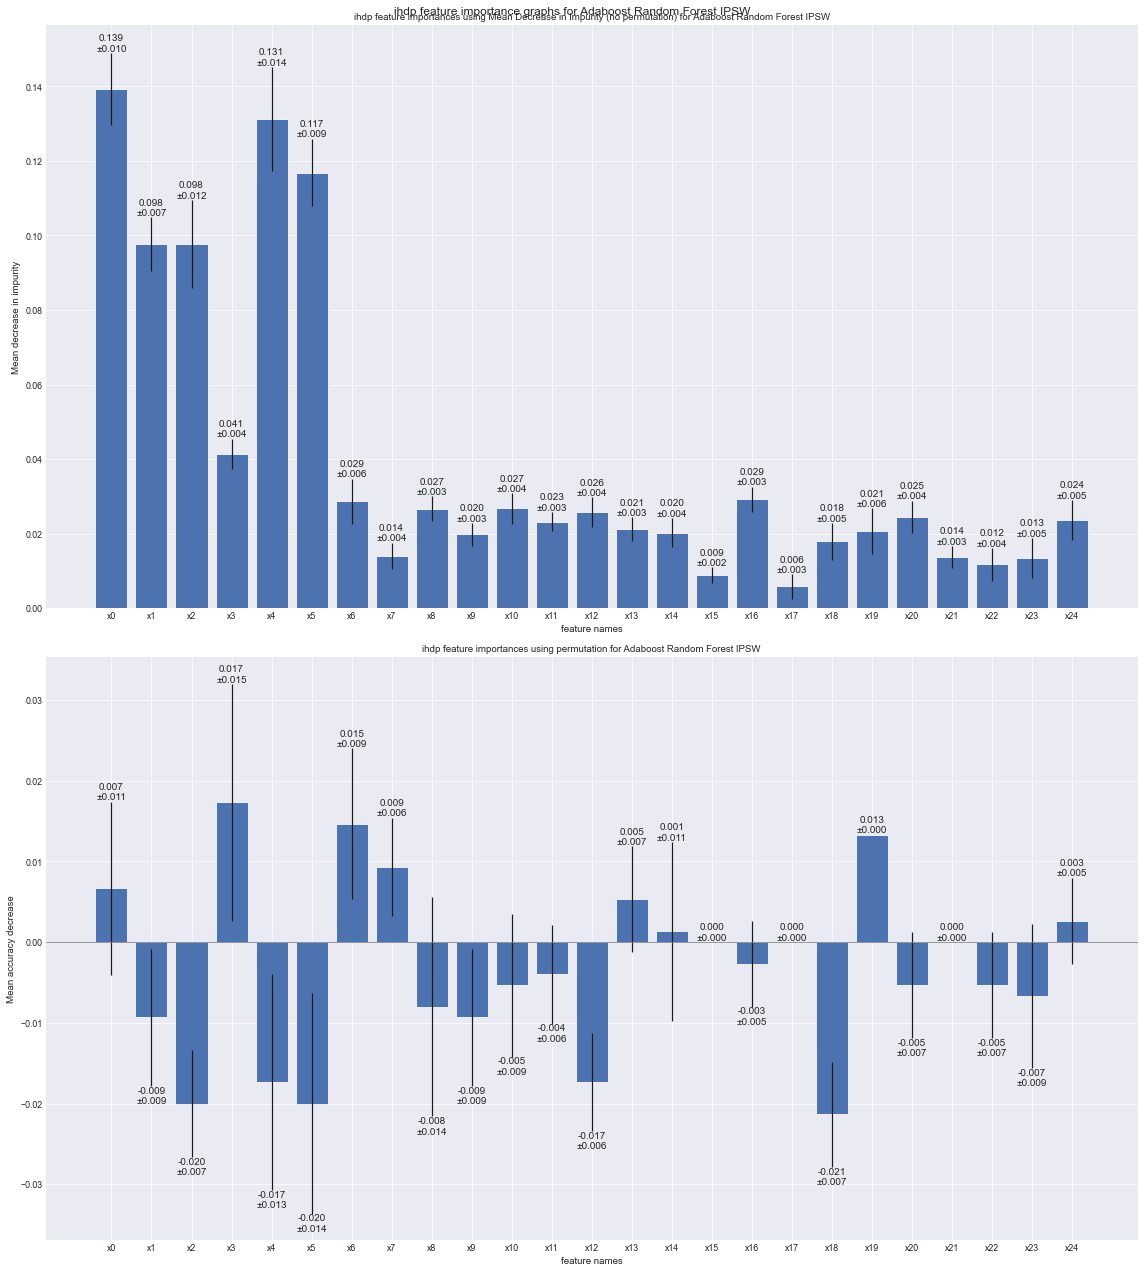

In [60]:

ada_rf_ipsw_best.importance_plotter().show()

In [ ]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

GridSearchResults summary sgd IPSW ihdp
	test score:	0.7982954545454546
	train score:0.6005529655529656
	yf score:	0.6342945380537675
GridSearchResults summary Random Forest IPSW ihdp
	test score:	0.7599431818181818
	train score:0.6591368816368817
	yf score:	0.891056891329042
GridSearchResults summary Adaboost Random Forest IPSW ihdp
	test score:	0.6974431818181819
	train score:0.6799572649572649
	yf score:	0.9587869178341537
GridSearchResults summary Adaboost SGD IPSW ihdp
	test score:	0.6392045454545454
	train score:0.49927609427609426
	yf score:	0.5031238167360849



In [ ]:
import assignment2.a2_utils.simple_learner_utils as slearner

best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).best_estimator_

ipsw_calc: slearner.IpswWrapper = slearner.IpswWrapper.make(
    best_ipsw_predictor,
    dataset_name=dataset
)

ipsw_calc.save_me()


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\PycharmProjects\\ce888\\project\\assignment2\\ihdp\\ihdp IPSW wrapper.pickle'

### And now using these weights to redo the earlier simple estimators

In [ ]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestRegressor(criterion="squared_error", random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":  rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

In [ ]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [ ]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

In [ ]:

rf_simple_ipsw_best.save_me()

In [ ]:
rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_iter",
    sample_weights=ipsw_calc,
    resource_param_values=ard_iter
)


In [ ]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [ ]:
print(ard_simple_ipsw_best.info)

ard_simple_ipsw_best.best_estimator_


In [ ]:
ard_simple_ipsw_best.save_me()

In [ ]:
ard_simple_best.importance_plotter().show()

In [ ]:
%%time

sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDRegressor(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"regressor__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter,
    sample_weights=ipsw_calc
)

In [ ]:

sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_ipsw_searched
)

In [ ]:

print(sgd_simple_ipsw_best.info)

sgd_simple_ipsw_best.best_estimator_

In [ ]:

sgd_simple_ipsw_best.save_me()

In [ ]:
sgd_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_ipsw_searched],
            RandomForestRegressor(random_state=seed()),
            RandomForestRegressor(random_state=seed(), max_depth=10),
            DecisionTreeRegressor(random_state=seed()),
            DecisionTreeRegressor(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    sample_weights=ipsw_calc,
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [ ]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


In [ ]:
ada_rf_simple_ipsw_best.save_me()

In [ ]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
%%time
ada_ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in ard_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost ARD simple IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=adaboost_estimators,
)


In [ ]:
ada_ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_ard_simple_ipsw_searched
)


In [ ]:
print(ada_ard_simple_ipsw_best.info)

ada_ard_simple_ipsw_best.best_estimator_


In [ ]:
ada_ard_simple_ipsw_best.save_me()

In [ ]:
ada_ard_simple_ipsw_best.importance_plotter().show()


In [ ]:
%%time


ada_sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostRegressor(
        random_state=seed()
    ),
    {
        #"regressor__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in ard.best_estimator_.named_steps.items()]
        #    ) for ard in ard_searched_dict.keys()
        #],
        #"regressor__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__loss": adaboost_loss,
        "estimator__base_estimator": [
            pl.clone_best_final_estimator for pl in sgd_simple_ipsw_searched
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost SGD simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.r2_score_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_sgd_simple_ipsw_searched
)

In [ ]:

print(ada_sgd_simple_ipsw_best.info)

ada_sgd_simple_ipsw_best.best_estimator_

In [ ]:

ada_sgd_simple_ipsw_best.save_me()

In [ ]:
ada_sgd_simple_ipsw_best.importance_plotter().show()

In [ ]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    sgd_simple_ipsw_best,
    ada_rf_simple_ipsw_best,
    ada_ard_simple_ipsw_best,
    ada_sgd_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [ ]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")

In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

# 5: The CATE stuff

In [ ]:
from econml.dml import CausalForestDML


import shap

In [ ]:
# obtaining train/test data for the CATE stuff.

X, Y = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_Y)

_, T = dfm.x_y(train=True, x_columns=df_utils.DatasetEnum.X_T)

x_test, y_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_Y)

_, t_test = dfm.x_y(train=False, x_columns=df_utils.DatasetEnum.X_T)


In [ ]:
%%time

causal_forest: CausalForestDML = CausalForestDML(
    criterion='het',
    n_estimators=10000,
    min_samples_leaf=10,
    max_depth=None,
    max_samples=0.5,
    discrete_treatment=True,
    honest=True,
    inference=True,
    cv=10,
    random_state=seed(),
    model_t=sklearn.base.clone(best_ipsw_predictor),
    model_y=sklearn.base.clone(best_simple_est),
    verbose=1
)

# fit train data to causal forest model
causal_forest.fit(Y, T, X=X, W=None)
# estimate the CATE with the test set
causal_forest.const_marginal_ate(x_test)

In [ ]:
slearner.standalone_feature_importance_plotter(
    predictor=causal_forest,
    x_data=x_test,
    y_data=y_test,
    predictor_name="Causal Forest",
    dataset_name=dataset
)

In [ ]:
%%time


# fit causal forest with default parameters
#shap_causal_forest = CausalForestDML()
#shap_causal_forest.fit(Y, T, X=X, W=None)

# calculate shap values of causal forest model
shap_values = causal_forest.shap_values(X)
# plot shap values
shap.summary_plot(shap_values['Y0']['T0'])

In [ ]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")